In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
from tests.leandro.tools import get_real_data, get_one_worm_data
from tests.leandro.plots import *
from tests.leandro.hierarchical_clustering_analysis import *
from minisom import MiniSom
import numpy as np
import pandas as pd

In [64]:
# Real data
dataset = get_real_data('/home/lrvnc/Projects/worm-graph/conf/dataset.yaml')


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50



In [65]:
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset)

Worm ID: worm3


In [105]:
X = oneWorm['smooth_calcium_data'] # (time, all neurons)
X = X[:, oneWorm['named_neurons_mask']]  # (time, named and acive neurons)

R = np.abs(np.corrcoef(X, rowvar=False)) # no correlated <- [0, 1] -> correlated
R = (R + R.T) / 2  # Make it symmetric (just in case) -> numerical error
D = 1 - R # Distance matrix: close <- [0, 1] -> far
np.fill_diagonal(D, 0) # Make diagonal 0 (just in case)

# Create a dataframe with D values and the neuron names
neuron_names = [label for _, label in oneWorm['slot_to_named_neuron'].items()]
distance_data = pd.DataFrame(D, columns=neuron_names, index=neuron_names)
ref_dict = load_reference(group_by='four')
label2number = {label: idx for idx, label in enumerate(['I', 'M', 'S', 'P'])}
dataset = create_ref_column(distance_data, ref_dict=ref_dict)
dataset

,ADAL,ADEL,ADLL,ADLR,AIBL,AIBR,AIML,AIMR,AIYL,AIYR,...,SMDVL,SMDVR,URAVL,URBL,URXL,URXR,URYDL,URYVL,URYVR,Reference
ADAL,0.000000,0.975510,0.804057,0.944760,0.691657,0.710011,0.945996,0.924645,0.579722,0.661637,...,0.889073,0.961596,0.497515,0.918978,0.980406,0.871708,0.476295,0.598533,0.544818,I
ADEL,0.975510,0.000000,0.713993,0.878020,0.749435,0.734778,0.763411,0.871635,0.783161,0.784173,...,0.773482,0.977929,0.497089,0.676118,0.761084,0.867585,0.932514,0.828956,0.857790,S
ADLL,0.804057,0.713993,0.000000,0.842920,0.411143,0.401123,0.565773,0.904375,0.762888,0.807202,...,0.865650,0.981504,0.906960,0.908092,0.859587,0.824738,0.608438,0.485585,0.470319,S
ADLR,0.944760,0.878020,0.842920,0.000000,0.680215,0.713890,0.812716,0.920954,0.637608,0.683292,...,0.936899,0.933547,0.863727,0.959248,0.946666,0.666080,0.743778,0.757158,0.787522,S
AIBL,0.691657,0.749435,0.411143,0.680215,0.000000,0.046219,0.421755,0.794129,0.441679,0.444517,...,0.992119,0.820962,0.957277,0.806885,0.621906,0.741303,0.373443,0.179499,0.198224,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URXL,0.980406,0.761084,0.859587,0.946666,0.621906,0.607199,0.768298,0.757201,0.802184,0.772801,...,0.830618,0.891836,0.991346,0.887919,0.000000,0.928570,0.862870,0.717312,0.655806,P
URXR,0.871708,0.867585,0.824738,0.666080,0.741303,0.763982,0.735170,0.780522,0.871009,0.787620,...,0.947805,0.839153,0.931917,0.894468,0.928570,0.000000,0.940173,0.801581,0.824337,P
URYDL,0.476295,0.932514,0.608438,0.743778,0.373443,0.375971,0.607740,0.965376,0.486155,0.541575,...,0.981816,0.827265,0.775695,0.710649,0.862870,0.940173,0.000000,0.279635,0.274569,S
URYVL,0.598533,0.828956,0.485585,0.757158,0.179499,0.172677,0.359086,0.973909,0.498510,0.482587,...,0.837382,0.925389,0.866490,0.632229,0.717312,0.801581,0.279635,0.000000,0.146047,S


In [106]:
data = dataset[dataset.columns[:-1]]
#data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

target = np.array([label2number[label] for label in dataset['Reference'].values])

label_names = {0: 'I', 1: 'M', 2: 'S', 3: 'P'}

In [108]:
# Initialization and training
n_neurons = 302
m_neurons = 302

som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)  # random training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.7039203958220607


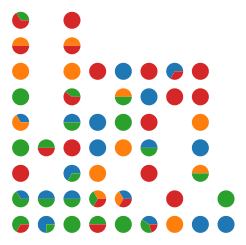

In [112]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(100, 100))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

#plt.legend(patches, label_names.values(), ncol=2, loc='best')
plt.show()